# AICE Professional

1. Tabular 데이터 Brain stroke prediction dataset
- 데이터 출처 : https://www.kaggle.com/datasets/zzettrkalpakbal/full-filled-brain-stroke-dataset
2. Text 데이터 Twitter Sentiment
- 데이터 출처 : https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis
3. Img 데이터 Flower_Classification_5class
- 데이터 출처 : https://www.kaggle.com/datasets/sauravagarwal/flower-classification

In [ ]:
# 라이브러리 임포트
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectFromModel


In [ ]:
# 딥러닝 라이브러리 임포트
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Flatten
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# AICE Professional-1 Tabular 데이터 분류 모델 만들기

In [ ]:
# Tabular traindata.csv 불러오기
# df = pd.read_csv('full_data_training.csv')
# 시험에서는 위와 비슷한 명칭으로 데이터를 불러서 사용합니다.

df = pd.read_csv('https://raw.githubusercontent.com/suku-7/AICE-Pro-share/refs/heads/main/brain_stroke_data_training.csv')
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
4976,Male,41.0,0,0,No,Private,Rural,70.15,29.8,formerly smoked,0
4977,Male,40.0,0,0,Yes,Private,Urban,191.15,31.1,smokes,0
4978,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,31.8,smokes,0
4979,Male,40.0,0,0,Yes,Private,Rural,83.94,30.0,smokes,0


In [ ]:
# Tabular 데이터 정보 확인
# 위의 df와 비교하면서 값하고 Dtype이 다른 부분이 있는지 확인
# 결측치 확인, 데이터 컬럼의 용도 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender                          4981 non-null   int64  
 1   age                             4981 non-null   float64
 2   hypertension                    4981 non-null   int64  
 3   heart_disease                   4981 non-null   int64  
 4   ever_married                    4981 non-null   int64  
 5   avg_glucose_level               4981 non-null   float64
 6   bmi                             4981 non-null   float64
 7   stroke                          4981 non-null   int64  
 8   work_type_Private               4981 non-null   bool   
 9   work_type_Self-employed         4981 non-null   bool   
 10  work_type_children              4981 non-null   bool   
 11  Residence_type_Urban            4981 non-null   bool   
 12  smoking_status_formerly smoked  49

In [ ]:
# Tabular 데이터 전처리 - 라벨 인코딩
df['gender'] = np.where(df['gender']=='Male', 1, 0)
df['ever_married'] = np.where(df['ever_married']=='Yes', 1, 0)

In [ ]:
# Tabular 데이터 전처리 - 결측치 확인
df.isnull().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
avg_glucose_level,0
bmi,0
stroke,0
work_type_Private,0
work_type_Self-employed,0


In [ ]:
# 결측치가 있다면, 버리거나 평균값으로 대체

from sklearn.impute import SimpleImputer #결측치 처리 용도

features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class', 'who', 'deck']
X = df[features]

# 수치형 데이터 결측치
numeric_features = ['age', 'fare']
numeric_imputer = SimpleImputer(strategy='mean')
X[numeric_features] = numeric_imputer.fit_transform(X[numeric_features])

# 범주형 데이터 결측치
categorical_features = ['embarked', 'deck', 'who', 'class', 'sex']
categorical_imputer = SimpleImputer(strategy='most_frequent')
X.loc[:, categorical_features] = categorical_imputer.fit_transform(X[categorical_features])

# 범주형 데이터 인코딩
label_encoders = {}
for feature in categorical_features:
    # 문자열로 변환 후 인코딩
    X[feature] = X[feature].astype(str)
    label_encoders[feature] = LabelEncoder()
    X.loc[:, feature] = label_encoders[feature].fit_transform(X[feature])

In [ ]:
# Tabular 데이터 전처리 - 원 핫 인코딩, object인 데이터만 분류
obj_col = df.select_dtypes('object').columns
obj_col

Index(['work_type', 'Residence_type', 'smoking_status'], dtype='object')

In [ ]:
# Tabular 데이터 전처리 - 원 핫 인코딩
df = pd.get_dummies(data=df, columns=obj_col, drop_first=True)

In [ ]:
# Tabular 데이터 컬럼 변경사항 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender                          4981 non-null   int64  
 1   age                             4981 non-null   float64
 2   hypertension                    4981 non-null   int64  
 3   heart_disease                   4981 non-null   int64  
 4   ever_married                    4981 non-null   int64  
 5   avg_glucose_level               4981 non-null   float64
 6   bmi                             4981 non-null   float64
 7   stroke                          4981 non-null   int64  
 8   work_type_Private               4981 non-null   bool   
 9   work_type_Self-employed         4981 non-null   bool   
 10  work_type_children              4981 non-null   bool   
 11  Residence_type_Urban            4981 non-null   bool   
 12  smoking_status_formerly smoked  49

In [ ]:
# Tabular 데이터 feature, label 분류
features = df.drop('stroke', axis=1)
labels = df['stroke']

In [ ]:
# Tabular 데이터 Train, valid 데이터셋 분할

from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((3984, 14), (997, 14), (3984,), (997,))

In [ ]:
from sklearn.preprocessing import StandardScaler

num_col = ['age','avg_glucose_level','bmi']

scaler = StandardScaler()
x_train[scale_col] = scaler.fit_transform(x_train[scale_col])
x_test[scale_col] = scaler.transform(x_test[scale_col])

########## 위 2줄과 동일하다.############
x_train_scaled = scaler.fit_transform(x_train[num_col])
x_test_scaled = scaler.transform(x_test[num_col])

x_train_scaled_df = pd.DataFrame(x_train_scaled, columns=num_col, index=x_train.index)
x_test_scaled_df = pd.DataFrame(x_test_scaled, columns=num_col, index=x_test.index)

x_train[num_col] = x_train_scaled_df
x_test[num_col] = x_test_scaled_df
#####################################

x_train, x_test

In [ ]:
# 라이브러리 임포트
"""
머신러닝 분류 모델의 경우 아래의 것들이 성능이 좋았어서 이것들만 사용했습니다.
LogisticRegression 이 연산 속도가 빨라서 먼저 실행해보고서 어느정도의 성능이 나오는지 보고
성능이 부족한거 같으면 RandomForestClassifier와 DecisionTreeClassifier를 사용했습니다.
딥러닝 분류 모델도 만들어서 모델 성능을 비교하고 마지막에 골라서 제출했습니다.
머신러닝 회귀 모델의 경우 DecisionTreeRegressor, RandomForestRegressor, 딥러닝 CNN 모델만 사용했습니다.
"""
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Tabular LogisticRegression 머신러닝 모델 분류 성능 확인
lgr = LogisticRegression()
lgr.fit(x_train, y_train)
lgr.score(x_valid, y_valid)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9498495486459378

In [ ]:
# Tabular SGDClassifier 머신러닝 모델 분류 성능 확인
sgdc = SGDClassifier()
sgdc.fit(x_train, y_train)
sgdc.score(x_valid, y_valid)

0.9017051153460381

In [ ]:
# Tabular DecisionTreeClassifier 머신러닝 모델 분류 성능 확인
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
dtc.score(x_valid, y_valid)

0.9037111334002006

In [ ]:
# Tabular RandomForestClassifier 머신러닝 모델 분류 성능 확인
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
rfc.score(x_valid, y_valid)

0.9468405215646941

In [ ]:
# 하이퍼파라미터 튜닝
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)

grid_search.fit(x_train, y_train)
print(f"\n최적 파라미터: {grid_search.best_params_}")
print(f"최고 정확도: {grid_search.best_score_:.3f}")

In [ ]:
# 최적화된 모델로 예측
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(x_test)
y_pred_test

print(f"\n최종 테스트 정확도: {accuracy_score(y_test, y_pred_test):.4f}")
print("\n분류 보고서:")
print(classification_report(y_test, y_pred_test))

# --- 6. 특성 선택 (Feature Selection) ---
# 특성 선택은 GridSearchCV 이후에 수행하는 것이 일반적입니다.
# 특성 선택 후 모델을 다시 훈련하는 것이 일반적인 흐름입니다.
# 다만, GridSearchCV는 이미 전체 특성으로 최적화되었으므로
# 여기서는 best_model 자체를 final_model로 사용하고, 특성 선택은 참고용으로만 두거나
# GridSearchCV 이전에 특성 선택을 포함하는 파이프라인을 구축하는 것이 더 바람직합니다.
# 현재 코드 흐름에서는 특성 선택 후 새로운 모델을 다시 훈련합니다.

# 특성 선택
selector = SelectFromModel(best_model, prefit=True)
X_train_selected = selector.transform(x_train)
X_test_selected = selector.transform(X_test)

# 선택된 특성으로 최종 모델 학습
final_model = RandomForestClassifier(**grid_search.best_params_, random_state=42)
final_model.fit(X_train_selected, y_train)



In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score
# 교차 검증 수행
cv_scores = cross_val_score(rfc, x_train, y_train, cv=5)
print(f"교차 검증 점수: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

In [ ]:
# Tabular 딥러닝 모델
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(x_train.shape[-1], )))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax')) #저는 2개 분류~여러개 분류 모두 softmax로 통일해서 사용했습니다.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Tabular 딥러닝 모델 compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Tabular 딥러닝 모델 훈련 fit
# Tabular는 es, mc, history에 숫자를 붙이지 않고 사용했습니다.
# 같은 코드 안에서 3개의 모델을 만들어서 비슷한 변수명에 숫자나, text, img를 붙였습니다.


es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
mc = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(
    x_train, y_train,
    epochs=10,
    validation_data=(x_valid, y_valid),
    callbacks=[es, mc],
    verbose=1
)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5457 - loss: 0.8668
Epoch 1: val_loss improved from inf to 0.30950, saving model to best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.5465 - loss: 0.8655 - val_accuracy: 0.9498 - val_loss: 0.3095
Epoch 2/10
113/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8701 - loss: 0.3780
Epoch 2: val_loss improved from 0.30950 to 0.25438, saving model to best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8726 - loss: 0.3744 - val_accuracy: 0.9498 - val_loss: 0.2544
Epoch 3/10
109/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9310 - loss: 0.2706
Epoch 3: val_loss improved from 0.25438 to 0.19375, saving model to best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9315 - loss: 0.2682 - val_accuracy: 0.9498 - val_loss: 0.1938
Epoch 4/10
115/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9385 - loss: 0.2296
Epoch 4: val_loss improved from 0.19375 to 0.18133, 

In [ ]:
# Tabular test 데이터셋.csv 읽기
#df5 = pd.read_csv('full_data_validation.csv')
# 시험에서는 위와 비슷한 명칭으로 데이터를 불러서 사용합니다.

df5 = pd.read_csv('https://raw.githubusercontent.com/suku-7/AICE-Pro-share/refs/heads/main/brain_stroke_data_validation.csv')
df5

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,31.555602,never smoked,1
1,Female,59.0,0,0,Yes,Private,Rural,76.15,30.242937,Unknown,1
2,Male,78.0,0,1,Yes,Private,Urban,219.84,30.698951,Unknown,1
3,Male,57.0,0,1,No,Govt_job,Urban,217.08,33.808410,Unknown,1
4,Male,58.0,0,0,Yes,Private,Rural,189.84,31.378534,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...
196,Male,41.0,0,0,No,Private,Rural,70.15,29.756631,formerly smoked,0
197,Male,40.0,0,0,Yes,Private,Urban,191.15,31.124172,smokes,0
198,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,31.798304,smokes,0
199,Male,40.0,0,0,Yes,Private,Rural,83.94,29.951301,smokes,0


In [ ]:
"""
위의 train, valid 데이터와 동일하게 대부분 데이터 전처리를 수행합니다.
훈련 데이터 셋에서는 중복, 결측치를 제거해서 모델의 분류 성능을 올려야 하지만,
테스트 데이터셋의 갯수를 줄이는 것은 (중복 삭제, 결측치 제거)는 하면 안됩니다.
저는 실습하다가 무의식적으로 하다가 지운 경우가 많았던거 같습니다.
"""
# Tabular test 데이터 전처리 - 라벨 인코딩
df5['gender'] = np.where(df5['gender']=='Male', 1, 0)
df5['ever_married'] = np.where(df5['ever_married']=='Yes', 1, 0)
df5.isnull().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0
smoking_status,0


In [ ]:
# Tabular Test 데이터 전처리 - 원 핫 인코딩
obj_col2 = df5.select_dtypes('object').columns
df5 = pd.get_dummies(data=df5, columns=obj_col2, drop_first=True)

In [ ]:
df5[scale_col] = scaler.transform(df5[scale_col])
df5

In [ ]:
# Tabular Test 데이터 feature, label 분류
x_test = df5.drop('stroke', axis=1)
y_test = df5['stroke']

In [ ]:
# Tabular Test 데이터로 머신러닝, 딥러닝 모델 성능 예측
lgr_y_pred = lgr.predict(x_test)
sgdc_y_pred = sgdc.predict(x_test)
dtc_y_pred = dtc.predict(x_test)
rfc_y_pred = rfc.predict(x_test)
model_y_pred = model.predict(x_test)
model_y_pred = np.argmax(model_y_pred, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


In [ ]:
lgr_y_pred, sgdc_y_pred, dtc_y_pred, rfc_y_pred, model_y_pred, model_y_pred

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0]),
 array([0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0,

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
print("\n최종 테스트 정확도:", accuracy_score(labels_test, rfc_y_pred))
print("\n분류 보고서:")
print(classification_report(labels_test, rfc_y_pred))

In [ ]:
"""
시험에서는 TestDataset에 대한 라벨이 부여되지 않아 아래와 같이 확인이 가능하지 않습니다.
현재 테스트 데이터셋은 라벨도 있고, 모델 성능이 비슷해보여서 비교하는 과정을 가졌습니다.

LogisticRegression 훈련 데이터셋 성능: 0.9498 (95%)
SGDClassifier 훈련 데이터셋 성능: 0.9498 (95%)
DecisionTreeClassifier 훈련 데이터셋 성능: 0.9067 (91%)
RandomForestClassifier 훈련 데이터셋 성능: 0.9478 (95%)
딥러닝 모델 훈련 데이터셋 성능: 0.9498 (95%)

시험 환경이었다면 모델성능이 비슷하다고 느껴지면
다른 실습 과정에서도 대부분 좋은 성능을 내는건 아래의 두 모델이라
RandomForestClassifier, 딥러닝 모델중 하나를 제출했을거 같습니다.

"""

In [ ]:
# Tabular 데이터 분류 시각화
from sklearn.metrics import classification_report, confusion_matrix

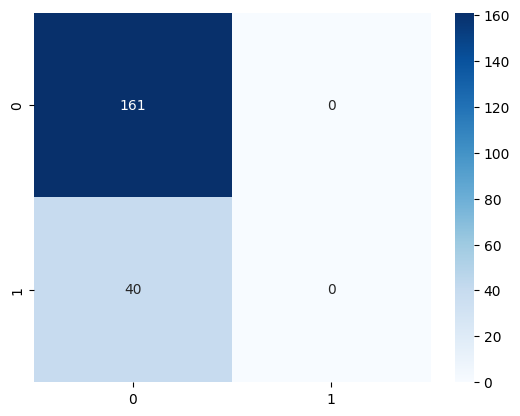

In [ ]:
# Logistic Regression 모델 성능 - 모델이 다 0을 예측해서 좋은거처럼 보였던거 같네요
cm = confusion_matrix(y_test, lgr_y_pred)
sns.heatmap(data=cm, annot=True, fmt='d', cmap='Blues')
plt.show()

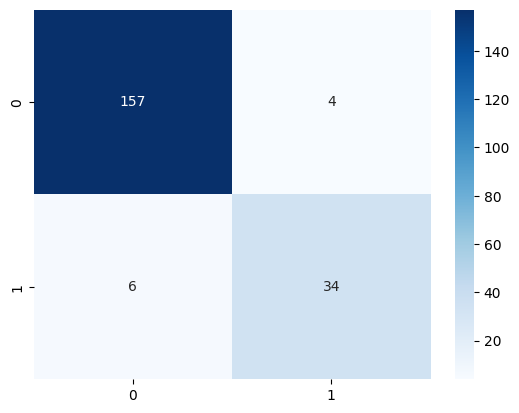

In [ ]:
# DecisionTreeClassifier 모델 성능 - 오 분류 성능이 꽤 좋아보입니다.
cm = confusion_matrix(y_test, dtc_y_pred)
sns.heatmap(data=cm, annot=True, fmt='d', cmap='Blues')
plt.show()

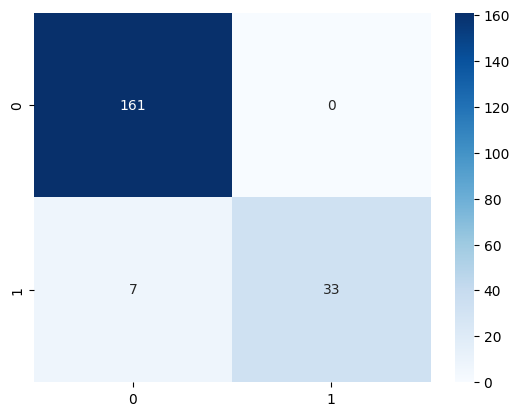

In [ ]:
# RandomForestClassifier 모델 성능 - 오 분류 성능이 꽤 좋아보입니다. DecisionTree와 비슷한 성능인거 같네요.
cm = confusion_matrix(y_test, rfc_y_pred)
sns.heatmap(data=cm, annot=True, fmt='d', cmap='Blues')
plt.show()

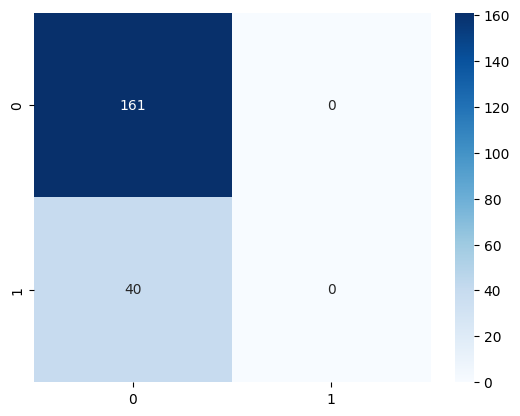

In [ ]:
# 딥러닝 모델 성능 - 모델이 다 0을 예측해서 좋은거처럼 보였던거 같네요
cm = confusion_matrix(y_test, model_y_pred)
sns.heatmap(data=cm, annot=True, fmt='d', cmap='Blues')
plt.show()

In [ ]:
# 모델중에 가장 성능이 좋아보이는 DecisionTreeClassifier의 예측값을 테스트 데이터셋 csv에 추가
df5['pred'] = rfc_y_pred
df5

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,pred
0,0,61.0,0,0,1,202.21,31.555602,1,False,True,False,False,False,True,False,0
1,0,59.0,0,0,1,76.15,30.242937,1,True,False,False,False,False,False,False,1
2,1,78.0,0,1,1,219.84,30.698951,1,True,False,False,True,False,False,False,1
3,1,57.0,0,1,0,217.08,33.808410,1,False,False,False,True,False,False,False,0
4,1,58.0,0,0,1,189.84,31.378534,1,True,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,1,41.0,0,0,0,70.15,29.756631,0,True,False,False,False,True,False,False,0
197,1,40.0,0,0,1,191.15,31.124172,0,True,False,False,True,False,False,True,0
198,0,45.0,1,0,1,95.02,31.798304,0,False,False,False,False,False,False,True,0
199,1,40.0,0,0,1,83.94,29.951301,0,True,False,False,False,False,False,True,0


In [ ]:
# 테스트 데이터셋 모델 성능 확인 - 안해도 되는 작업이지만 라벨이 있어서 한번 더 확인해봤습니다.
correct_count = sum(df5['stroke']==df5['pred'])
total_count = len(df5)
model_accuracy = correct_count/total_count
print(f'model_accuracy : {model_accuracy:.2f}')

model_accuracy : 0.97


In [ ]:
# Tabular 머신러닝 모델 저장을 위한 joblib 라이브러리 임포트
import joblib
joblib.dump(rfc, '01012345678_1.joblib') # Tabular 데이터는 '연락처_1.joblib' 으로 저장

['01012345678_1.joblib']

In [ ]:
# Tabular 모델 저장 확인
tab_load_model = joblib.load('01012345678_1.joblib')

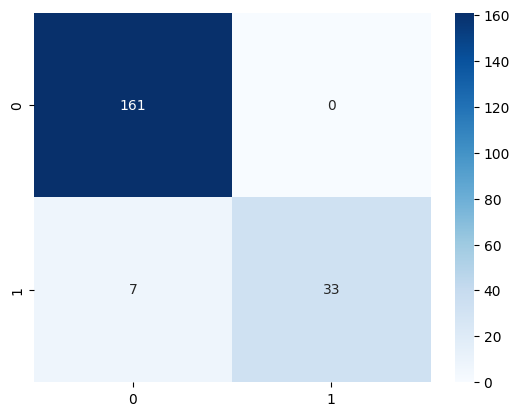

In [ ]:
# Tabular 모델 불러와서 모델 성능 확인 / 시험에서는 불필요
tab_load_y_pred = tab_load_model.predict(x_test)
cm = confusion_matrix(y_test, tab_load_y_pred)
sns.heatmap(data=cm, annot=True, fmt='d', cmap='Blues')
plt.show()

In [ ]:
# Tabular 모델 테스트 데이터셋.csv 저장
df5.to_csv('01012345678_1.csv', index=False, encoding='utf-8') # Tabular 데이터는 '연락처_1.csv' 으로 저장
df6 = pd.read_csv('01012345678_1.csv') # 데이터 저장 확인
df6

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,pred
0,0,61.0,0,0,1,202.21,31.555602,1,False,True,False,False,False,True,False,0
1,0,59.0,0,0,1,76.15,30.242937,1,True,False,False,False,False,False,False,1
2,1,78.0,0,1,1,219.84,30.698951,1,True,False,False,True,False,False,False,1
3,1,57.0,0,1,0,217.08,33.808410,1,False,False,False,True,False,False,False,0
4,1,58.0,0,0,1,189.84,31.378534,1,True,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,1,41.0,0,0,0,70.15,29.756631,0,True,False,False,False,True,False,False,0
197,1,40.0,0,0,1,191.15,31.124172,0,True,False,False,True,False,False,True,0
198,0,45.0,1,0,1,95.02,31.798304,0,False,False,False,False,False,False,True,0
199,1,40.0,0,0,1,83.94,29.951301,0,True,False,False,False,False,False,True,0


## Version2 (titanic dataset)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectFromModel
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 로드
df = sns.load_dataset('titanic')

df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [ ]:
df.isnull().sum()

,0
survived,0
pclass,0
sex,0
age,177
sibsp,0
parch,0
fare,0
embarked,2
class,0
who,0


In [ ]:
# NaN이 많은 값과 중복되는 의미를 가지는 컬럼을 삭제,
#여기서는 class와 alive를 삭제하면 라벨인코딩을 안해도 되지만 라벨인코딩 테스트를 위해 선택한
df.drop(columns=['deck','survived','pclass','who','embark_town'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   sex          891 non-null    object  
 1   age          714 non-null    float64 
 2   sibsp        891 non-null    int64   
 3   parch        891 non-null    int64   
 4   fare         891 non-null    float64 
 5   embarked     889 non-null    object  
 6   class        891 non-null    category
 7   adult_male   891 non-null    bool    
 8   embark_town  889 non-null    object  
 9   alive        891 non-null    object  
 10  alone        891 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(2), object(4)
memory usage: 58.6+ KB


In [ ]:
df['sex'] = np.where(df['sex']=='male',1,0)
df['alive'] = np.where(df['alive']=='yes',1,0)
df

,sex,age,sibsp,parch,fare,embarked,class,adult_male,embark_town,alive,alone
0,1,22.0,1,0,7.2500,S,Third,True,Southampton,0,False
1,0,38.0,1,0,71.2833,C,First,False,Cherbourg,1,False
2,0,26.0,0,0,7.9250,S,Third,False,Southampton,1,True
3,0,35.0,1,0,53.1000,S,First,False,Southampton,1,False
4,1,35.0,0,0,8.0500,S,Third,True,Southampton,0,True
...,...,...,...,...,...,...,...,...,...,...,...
886,1,27.0,0,0,13.0000,S,Second,True,Southampton,0,True
887,0,19.0,0,0,30.0000,S,First,False,Southampton,1,True
888,0,NaN,1,2,23.4500,S,Third,False,Southampton,0,False
889,1,26.0,0,0,30.0000,C,First,True,Cherbourg,1,True


In [ ]:
df['class'].value_counts()

,count
class,
Third,491
First,216
Second,184


In [ ]:
obj_col = df.select_dtypes('object').columns
df = pd.get_dummies(df, columns=obj_col, drop_first=True)
df

,sex,age,sibsp,parch,fare,class,adult_male,alive,alone,embarked_Q,embarked_S,embark_town_Queenstown,embark_town_Southampton
0,1,22.0,1,0,7.2500,Third,True,0,False,False,True,False,True
1,0,38.0,1,0,71.2833,First,False,1,False,False,False,False,False
2,0,26.0,0,0,7.9250,Third,False,1,True,False,True,False,True
3,0,35.0,1,0,53.1000,First,False,1,False,False,True,False,True
4,1,35.0,0,0,8.0500,Third,True,0,True,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,1,27.0,0,0,13.0000,Second,True,0,True,False,True,False,True
887,0,19.0,0,0,30.0000,First,False,1,True,False,True,False,True
888,0,NaN,1,2,23.4500,Third,False,0,False,False,True,False,True
889,1,26.0,0,0,30.0000,First,True,1,True,False,False,False,False


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   sex                      891 non-null    int64   
 1   age                      714 non-null    float64 
 2   sibsp                    891 non-null    int64   
 3   parch                    891 non-null    int64   
 4   fare                     891 non-null    float64 
 5   class                    891 non-null    category
 6   adult_male               891 non-null    bool    
 7   alive                    891 non-null    int64   
 8   alone                    891 non-null    bool    
 9   embarked_Q               891 non-null    bool    
 10  embarked_S               891 non-null    bool    
 11  embark_town_Queenstown   891 non-null    bool    
 12  embark_town_Southampton  891 non-null    bool    
dtypes: bool(6), category(1), float64(2), int64(4)
memory usage: 48.1 

In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:
# 수치형
num_col = ['age']
num_impute = SimpleImputer(strategy='mean')
df[num_col]=num_impute.fit_transform(df[num_col])
df.isnull().sum()

In [ ]:
char_col = ['embarked']
char_impute = SimpleImputer(strategy='most_frequent')
df[char_col] = char_impute.fit_transform(df[char_col])
df.isnull().sum()

In [ ]:
df.info()

In [ ]:
features = df.drop('alive', axis=1)
labels = df['alive']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [ ]:
# 4. 훈련 데이터의 'fare'와 'age' 컬럼에 fit_transform 적용
# 스케일링할 컬럼 리스트 정의
columns_to_scale = ['fare', 'age']

# X_train에서 스케일링할 컬럼만 선택하여 fit_transform 수행
X_train_scaled_features = scaler.fit_transform(X_train[columns_to_scale])

# 스케일링된 데이터를 DataFrame으로 다시 변환 (컬럼 이름 유지)
X_train_scaled_features_df = pd.DataFrame(X_train_scaled_features, columns=columns_to_scale, index=X_train.index)

# X_train의 원본 'fare'와 'age' 컬럼을 스케일링된 값으로 대체
# 이 과정을 통해 X_train은 스케일링된 'fare', 'age'와 원본 다른 컬럼들을 모두 포함하게 됩니다.
X_train[columns_to_scale] = X_train_scaled_features_df


# 5. 테스트 데이터의 'fare'와 'age' 컬럼에 transform만 적용 (fit은 다시 하지 않음!)
X_test_scaled_features = scaler.transform(X_test[columns_to_scale])

# 스케일링된 데이터를 DataFrame으로 다시 변환
X_test_scaled_features_df = pd.DataFrame(X_test_scaled_features, columns=columns_to_scale, index=X_test.index)

# X_test의 원본 'fare'와 'age' 컬럼을 스케일링된 값으로 대체
X_test[columns_to_scale] = X_test_scaled_features_df

print("\n\n스케일링 후 훈련 데이터 (X_train) head:")
print(X_train[['fare', 'age']].head())
print("\n스케일링 후 테스트 데이터 (X_test) head:")
print(X_test[['fare', 'age']].head())

print("\n스케일링 후 X_train 전체 컬럼 (일부만 표시):")
print(X_train.head())

print("\n스케일링 후 X_test 전체 컬럼 (일부만 표시):")
print(X_test.head())

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2,5,10],
    'min_samples_leaf' : [1,2,4]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)
grid_search.best_params_, grid_search.best_score_

In [ ]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:

print(classification_report(y_test, y_pred))

In [ ]:
final_model = RandomForestClassifier(**grid_search.best_params_, random_state=42)
final_model.fit(X_train, y_train)

In [ ]:
features

In [ ]:
# 5. 테스트 데이터의 'fare'와 'age' 컬럼에 transform만 적용 (fit은 다시 하지 않음!)
valid_scaled_features = scaler.transform(features[columns_to_scale])

# 스케일링된 데이터를 DataFrame으로 다시 변환
valid_scaled_features_df = pd.DataFrame(valid_scaled_features, columns=columns_to_scale, index=features.index)

# X_test의 원본 'fare'와 'age' 컬럼을 스케일링된 값으로 대체
features[columns_to_scale] = valid_scaled_features_df

In [ ]:
y_pred2 = final_model.predict(features)
df['predicted_survived'] = y_pred2
df

In [ ]:
df[df['alive'] != df['predicted_survived']]

In [ ]:
# Tabular 머신러닝 모델 저장을 위한 joblib 라이브러리 임포트
import joblib
joblib.dump(rfc, '01012345678_1.joblib') # Tabular 데이터는 '연락처_1.joblib' 으로 저장

In [ ]:
df.to_csv('01012345678.csv', encoding='utf-8', index=False)